# Exponentially distributed cluster sizes 

In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from numpy import log10, array, pi, mean, std 
from scipy.stats import gaussian_kde
import os, sys

font = {'family' : 'Arial',
        'size'   : 18}

plt.rc('font', **font)


def ProgressBar(jobName, progress, length=40):
    completionIndex = round(progress*length)
    msg = "\r{} : [{}] {}%".format(jobName, "*"*completionIndex + "-"*(length-completionIndex), round(progress*100))
    if progress >= 1: msg += "\r\n"
    sys.stdout.write(msg)
    sys.stdout.flush()

def model(z,t, params):
    kf, kr, A, n = params
    F, G = z
    dFdt = kf*F*G**2 *A - kr*F
    dGdt = -dFdt
    return [dFdt, dGdt]

def getActinDynamics(IC = [1,10], params=(1,1,1,1)):
    kf, kr, A, n = params
    # long enough to reach steady state 
    t = np.linspace(0, 500, 1000)
    #FA = []
    zList = [odeint(model, IC, t, args=((kf,kr,a,n),)) for a in A]
    FA = [z[-1,0] for z in zList]
    
    return FA

def getClusters_exp(n, R, A):
    V_large = (4/3)*pi*R**3
    
    r = n**-(1/3) * R 
    
    r_data = np.random.exponential(scale=r, size=n)
    
    vs = (4/3)*pi*r_data**3 # volume small 
    tot_vs = sum(vs)
    scaled_factor = (V_large / tot_vs)**(1/3) # this factor enforces the volume conservation 
    rs = r_data * scaled_factor
    vs_adjusted = (4/3)*pi*rs**3 
    surf_area = 4*pi*rs**2 
    arp_fraction = vs_adjusted/sum(vs_adjusted) # Arp partitioning is proportional to the relative volume 
    arp_count = arp_fraction * A
    arp_density = arp_count/surf_area 
    arp_density = np.clip(arp_density, a_min=0, a_max=None)
    
    return arp_density, vs_adjusted

def expDist(nList, numRuns, R=1, A=1):
    FList = []
    Ferr = []
    Astat, Fstat = [], []
    N_elem = len(nList)
    for i,n in enumerate(nList):
        tmpF = []
        F_stat, A_stat = [], []
        for _ in range(numRuns):
            arp_density, vs = getClusters_exp(n, R=R, A=A)
            F = getActinDynamics(IC=[0.01, 100], params=(0.001,1,arp_density,n))
            F_stat.extend(F)
            A_stat.extend(arp_density)
            tmpF.append(sum(F))
            
        FList.append(mean(array(tmpF)))
        Ferr.append(std(array(tmpF)))
        
        Astat.append(A_stat)
        Fstat.append(F_stat)
        ProgressBar('Progress', (i+1)/N_elem, length=40)
    
    return FList, Ferr, [Astat, Fstat] 



# Per cluster F-actin production as a function of cluster number


Cluster size distribution: Exponential 

Progress : [****************************************] 100%


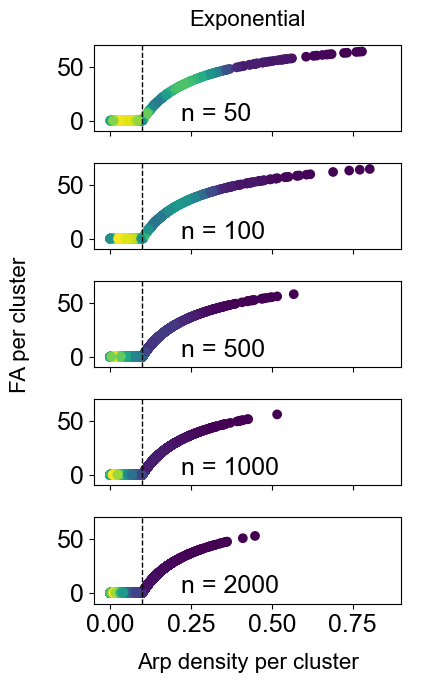

In [2]:
nList = [50,100,500,1000,2000] 

FList = []

alpha = 1 # Surface density of Arp2/3 at the single large cluster

R = 100

A = alpha * 4*pi*R*R # Count of Arp2/3

numRuns = 10 

print('\nCluster size distribution: Exponential \n')

distPlot = True 

FList, Ferr, runStat  = expDist(nList, numRuns=numRuns, R=R, A=A)

#np.savetxt(f'Exp_R{R}.txt', array([nList, FList]).T, fmt='%.4e', header='nCluster \t FA_global)    
 
if distPlot:
    A_stat, F_stat = runStat
    fig, axs = plt.subplots(len(nList), figsize=(5,7.5))
    fig.add_subplot(111,frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    #fig.subplots_adjust(hspace=0.1)
    plt.title('Exponential', pad=14, fontsize=16)
    plt.xlabel('Arp density per cluster', fontsize=16, labelpad=12)
    plt.ylabel('FA per cluster', fontsize=16, labelpad=14)
    
    for a in axs:
        a.label_outer()
        a.set_xlim(-0.05, 0.9)
        a.set_ylim(-10, 70)
    
    i = 0
    for A, F in zip(A_stat, F_stat):
        xy = np.vstack([A,F])
        z = gaussian_kde(xy)(xy)
        axs[i].scatter(A, F, c=z)
        axs[i].text(0.22,0.2, f'n = {nList[i]}')
        axs[i].axvline(0.1, ls='dashed', lw=1, c='k')
        i += 1
        
    plt.tight_layout()
    plt.show()
    

# Global F-actin production as a function of cluster count


Cluster size distribution: Exponential 

Progress : [****************************************] 100%


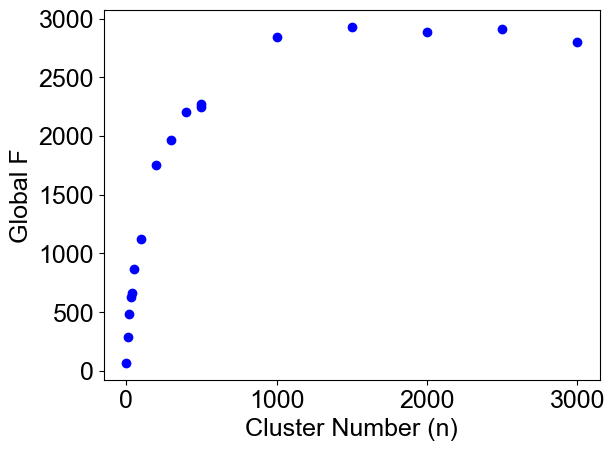

In [3]:
nList = np.arange(500, 3500, 500)

#nList = np.arange(50, 3050, 50) # more sampling 

nList = [1,10,20,30,40,50,100,200,300,400,500] + list(nList)

FList = []

alpha = 1 # Surface density of Arp2/3 at the single large cluster

R = 100

A = alpha * 4*pi*R*R # Count of Arp2/3

numRuns = 10 

print('\nCluster size distribution: Exponential \n')


FList, Ferr, runStat  = expDist(nList, numRuns=numRuns, R=R, A=A)

plt.plot(nList, FList, 'bo')

plt.xlabel('Cluster Number (n)')
plt.ylabel('Global F')
plt.show()